In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['BSSC Billing ALL (new)','BSSC Senior','Commercial COAST','Wireline_BSSC_ ETC_Processing']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                   Queue  Forecasted_AHT  Forecasted_CV  \
0 2018-04-04 02:30:00  BSSC Billing ALL (new)             NaN            NaN   
1 2018-04-04 02:45:00  BSSC Billing ALL (new)             NaN            NaN   
2 2018-04-04 03:00:00  BSSC Billing ALL (new)             NaN            NaN   

   Actual_AHT  Actual_CV  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-01 00:00:00        0.0
1 2017-01-01 00:15:00        0.0
2 2017-01-01 00:30:00        0.0

In [4]:
weekly_cv = grouped_cv.resample('W-MON', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-02        0.0
2017-01-09      244.0
2017-01-16      226.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-01 00:00:00            0.0
1 2017-01-01 00:15:00            0.0
2 2017-01-01 00:30:00            0.0

In [6]:
weekly_fcv = grouped_fcv.resample('W-MON', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02            0.0
2017-01-09          277.0
2017-01-16          275.0

In [7]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds  for_y
296 2022-09-05  700.0
297 2022-09-12  914.0
298 2022-09-19  195.0

In [8]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds       y
296 2022-09-05   691.0
297 2022-09-12  1015.0
298 2022-09-19   212.0

#### Initiate Prophet

In [9]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=104, freq='W-MON')
future.tail(3)

ds
400 2024-09-02
401 2024-09-09
402 2024-09-16

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
400 2024-09-02  678.325181  463.772139  893.251073
401 2024-09-09  659.087512  439.723644  860.948387
402 2024-09-16  683.613075  466.405012  903.253623

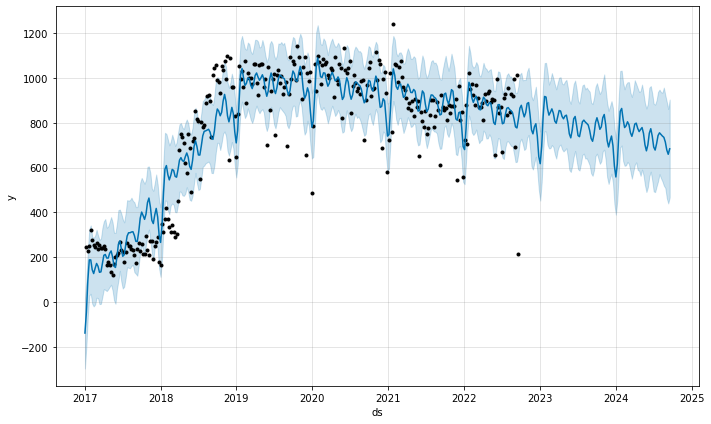

In [12]:
fig1 = m.plot(forecast)

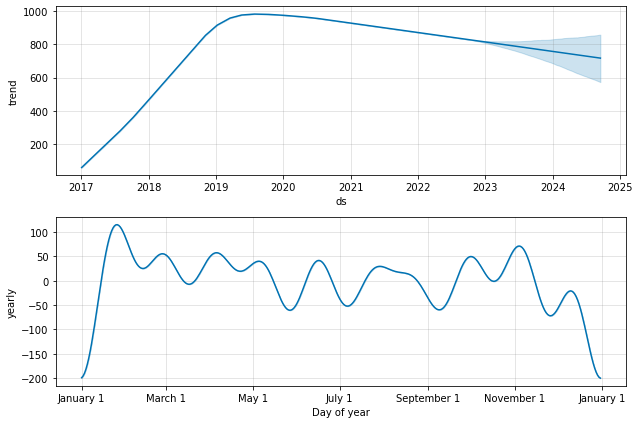

In [13]:
fig2 = m.plot_components(forecast)


In [14]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

In [15]:
plot_components_plotly(m, forecast)


In [16]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
400 2024-09-02  719.871569  463.772139  893.251073   579.623183   857.220571   
401 2024-09-09  718.778814  439.723644  860.948387   576.257847   858.646064   
402 2024-09-16  717.686058  466.405012  903.253623   572.891956   859.089060   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
400      -41.546388            -41.546388            -41.546388 -41.546388   
401      -59.691301            -59.691301            -59.691301 -59.691301   
402      -34.072983            -34.072983            -34.072983 -34.072983   

     yearly_lower  yearly_upper  multiplicative_terms  \
400    -41.546388    -41.546388                   0.0   
401    -59.691301    -59.691301                   0.0   
402    -34.072983    -34.072983                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
400                         0.0                         0.0  678.325181  
401                         0.0                         0.0  659.087512  
402                         0.0                         0.0  683.613075

#### Cross Validation

In [17]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 43 forecasts with cutoffs between 2021-01-09 00:00:00 and 2022-08-20 00:00:00


  0%|          | 0/43 [00:00<?, ?it/s]

ds         yhat  yhat_lower   yhat_upper       y     cutoff
0 2021-01-11   925.602969  789.892293  1065.166050  1024.0 2021-01-09
1 2021-01-18  1054.978708  912.852314  1198.111037   759.0 2021-01-09
2 2021-01-25  1099.216932  961.307282  1243.103917  1242.0 2021-01-09

In [18]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon           mse        rmse        mae      mape     mdape     smape  \
0  2 days  12911.156321  113.627269  88.780305  0.112699  0.082182  0.104604   
1  9 days  12433.423399  111.505262  91.795184  0.107185  0.094722  0.103849   
2 16 days  13904.119585  117.915731  91.641393  0.116889  0.088244  0.107921   

   coverage  
0  0.790698  
1  0.837209  
2  0.813953

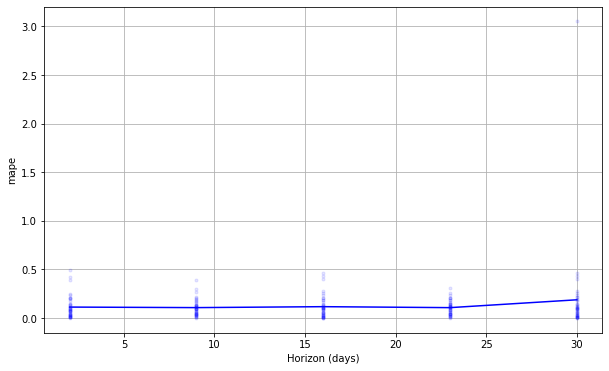

In [19]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [20]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [21]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 403...Done. 0.18700265884399414 total seconds have elapsed.


## AHT Forecasts

In [22]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-01 00:00:00      0.0
1 2017-01-01 00:15:00      0.0
2 2017-01-01 00:30:00      0.0

In [23]:
combined_aht = grouped_aht
combined_aht['Actual_AHT'] = grouped_aht['Adj_AHT'] / grouped_cv['Actual_CV']
combined_aht.head(3)

DateTime  Adj_AHT  Actual_AHT
0 2017-01-01 00:00:00      0.0         NaN
1 2017-01-01 00:15:00      0.0         NaN
2 2017-01-01 00:30:00      0.0         NaN

In [24]:
subdaily_adj = grouped_aht[['DateTime','Adj_AHT']]
subdaily_adj['Adj_AHT'] = subdaily_adj['Adj_AHT'].replace(0, np.nan)
weekly_adj = subdaily_adj.resample('W-MON', on='DateTime').sum()
weekly_adj.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_7324\291837847.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_AHT
DateTime           
2017-01-02      0.0
2017-01-09  85886.0
2017-01-16  83190.0

In [25]:
subdaily_cv = grouped_cv[['DateTime','Actual_CV']]
weekly_cv = subdaily_cv.resample('W-MON', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-02        0.0
2017-01-09      244.0
2017-01-16      226.0

In [26]:
combined_aht = weekly_adj.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_adj['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
296 2022-09-05  648.680174
297 2022-09-12  606.215764
298 2022-09-19  476.004717

In [27]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-01 00:00:00      0.0
1 2017-01-01 00:15:00      0.0
2 2017-01-01 00:30:00      0.0

In [28]:
combined_for = grouped_for
combined_for['Forecasted_AHT'] = grouped_for['Adj_for'] / grouped_fcv['Forecasted_CV']
combined_for.head(3)

DateTime  Adj_for  Forecasted_AHT
0 2017-01-01 00:00:00      0.0             NaN
1 2017-01-01 00:15:00      0.0             NaN
2 2017-01-01 00:30:00      0.0             NaN

In [29]:
subdaily_for = grouped_for[['DateTime','Adj_for']]
subdaily_for['Adj_for'] = subdaily_for['Adj_for'].replace(0, np.nan)
weekly_adj_for = subdaily_for.resample('W-MON', on='DateTime').sum()
weekly_adj_for.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_7324\675107983.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_for
DateTime           
2017-01-02      0.0
2017-01-09  96472.0
2017-01-16  97412.0

In [30]:
subdaily_fcv = grouped_fcv[['DateTime','Forecasted_CV']]
weekly_fcv = subdaily_fcv.resample('W-MON', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02            0.0
2017-01-09          277.0
2017-01-16          275.0

In [31]:
combined_for = weekly_adj_for.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_adj_for['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
296 2022-09-05  622.580000
297 2022-09-12  551.561269
298 2022-09-19  675.076923

#### Initiate Prophet

In [32]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = m.make_future_dataframe(periods=104, freq='W-MON')
future.tail(3)

ds
400 2024-09-02
401 2024-09-09
402 2024-09-16

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
400 2024-09-02  594.113764  540.831810  648.599819
401 2024-09-09  589.471547  532.121348  644.501410
402 2024-09-16  588.069239  531.243347  641.058293

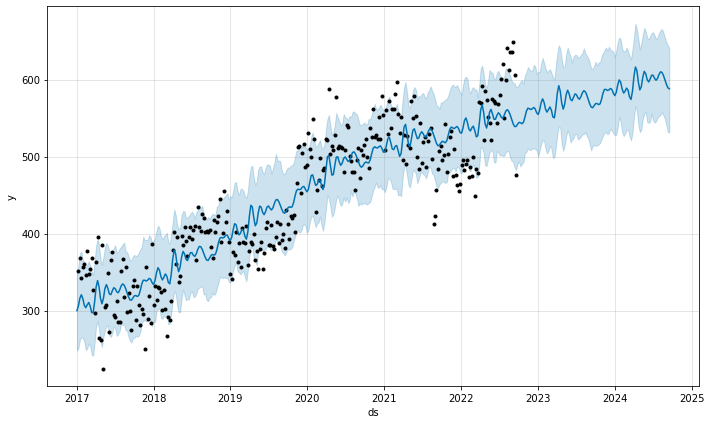

In [35]:
fig1 = m.plot(forecast)

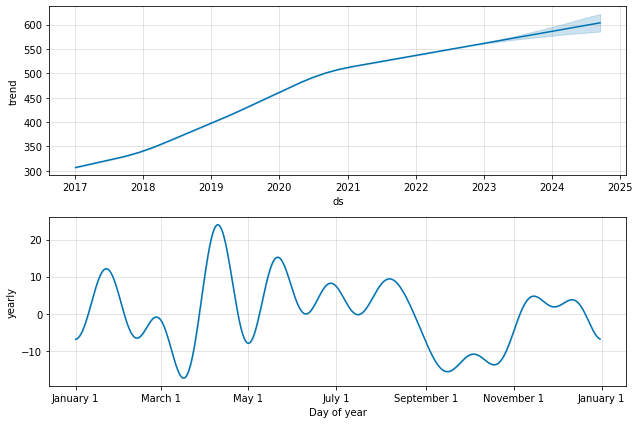

In [36]:
fig2 = m.plot_components(forecast)


In [37]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

In [38]:
plot_components_plotly(m, forecast)


In [39]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
400 2024-09-02  602.693948  540.831810  648.599819   585.390507   620.424775   
401 2024-09-09  603.167160  532.121348  644.501410   585.513429   620.966664   
402 2024-09-16  603.640372  531.243347  641.058293   585.675619   621.578531   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
400       -8.580184             -8.580184             -8.580184  -8.580184   
401      -13.695613            -13.695613            -13.695613 -13.695613   
402      -15.571133            -15.571133            -15.571133 -15.571133   

     yearly_lower  yearly_upper  multiplicative_terms  \
400     -8.580184     -8.580184                   0.0   
401    -13.695613    -13.695613                   0.0   
402    -15.571133    -15.571133                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
400                         0.0                         0.0  594.113764  
401                         0.0                         0.0  589.471547  
402                         0.0                         0.0  588.069239

#### Cross Validate

In [40]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 43 forecasts with cutoffs between 2021-01-09 00:00:00 and 2022-08-20 00:00:00


  0%|          | 0/43 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-11  553.904098  507.692016  597.327537  560.755859 2021-01-09
1 2021-01-18  569.184401  524.541681  614.787146  529.022398 2021-01-09
2 2021-01-25  574.633530  531.399786  622.038453  572.774557 2021-01-09

In [41]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  2575.903921  50.753364  39.857180  0.076655  0.058396  0.075337   
1  9 days  3495.252285  59.120659  49.206061  0.093295  0.090557  0.092247   
2 16 days  3734.915671  61.113956  49.420026  0.093939  0.074980  0.092757   

   coverage  
0  0.651163  
1  0.534884  
2  0.604651

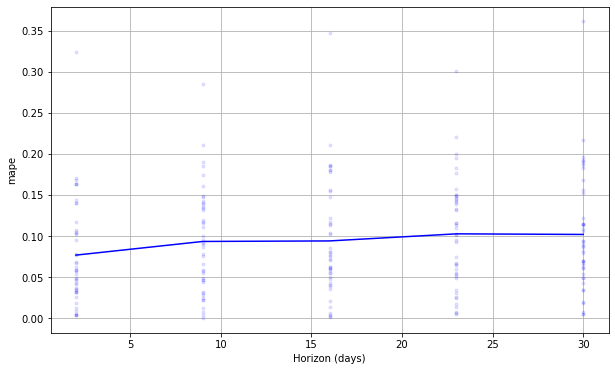

In [42]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [43]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [44]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 403...Done. 0.2099924087524414 total seconds have elapsed.
